* Import the necessary libraries
* Import BertForSequenceClassification and BertTokenizer from transformers

In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
from transformers import BertTokenizerFast

Get and load the data from below link -
https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction

In [7]:
df = pd.read_csv('/content/fake_job_postings.csv')

In [8]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [9]:
df.columns

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')

In [10]:
df.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
df.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [12]:
df.drop(columns=['salary_range', 'job_id'], inplace=True)

In [13]:
df.fillna("", inplace=True)

In [14]:
df['text'] = df[['title', 'location', 'department', 'company_profile', 'description', 'requirements', 'benefits', 'employment_type', 'required_education', 'industry', 'function']].agg(' '.join, axis=1)

In [15]:
df.text[0]

"Marketing Intern US, NY, New York Marketing We're Food52, and we've created a groundbreaking and award-winning cooking site. We support, connect, and celebrate home cooks, and give them everything they need in one place.We have a top editorial, business, and engineering team. We're focused on using technology to find new and better ways to connect people around their specific food interests, and to offer them superb, highly curated information about food and cooking. We attract the most talented home cooks and contributors in the country; we also publish well-known professionals like Mario Batali, Gwyneth Paltrow, and Danny Meyer. And we have partnerships with Whole Foods Market and Random House.Food52 has been named the best food website by the James Beard Foundation and IACP, and has been featured in the New York Times, NPR, Pando Daily, TechCrunch, and on the Today Show.We're located in Chelsea, in New York City. Food52, a fast-growing, James Beard Award-winning online food communi

In [16]:
columns_to_drop = ['title', 'location', 'department', 'company_profile', 'description',
                   'requirements', 'benefits', 'employment_type', 'required_experience',
                   'required_education', 'industry', 'function']

df.drop(columns=columns_to_drop, inplace=True)

In [17]:
df.head()

,telecommuting,has_company_logo,has_questions,fraudulent,text
0,0,1,0,0,"Marketing Intern US, NY, New York Marketing We..."
1,0,1,0,0,"Customer Service - Cloud Video Production NZ, ..."
2,0,1,0,0,"Commissioning Machinery Assistant (CMA) US, IA..."
3,0,1,0,0,"Account Executive - Washington DC US, DC, Wash..."
4,0,1,1,0,"Bill Review Manager US, FL, Fort Worth SpotSo..."


In [18]:
df.columns

Index(['telecommuting', 'has_company_logo', 'has_questions', 'fraudulent',
       'text'],
      dtype='object')

In [19]:
df['text'] = df['text'].apply(str)
df['fraudulent'] = df['fraudulent'].astype(int)

In [20]:
X = df['text'].values
y = df['fraudulent'].values

In [21]:
X = df.drop(columns=['fraudulent'])
y = df['fraudulent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

* Below line of code initializes a tokenizer object for the BERT model.  

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

*  This line of code initializes a DistilBERT tokenizer from the pre-trained 'distilbert-base-uncased' model, which means it loads the pre-trained tokenizer for the DistilBERT model trained on uncased text data.

In [23]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

* The code utilizes the batch_encode_plus() method of the tokenizer object to tokenize and encode a batch of text inputs for both training and testing data.
* For both training and testing datasets (X_train['text'] and X_test['text'] respectively), the text data is provided as a list, assumed to be contained within the column labeled 'text'.
* The resulting encoded data is returned as PyTorch tensors (return_tensors='pt'), and after encoding, the input sequences (input_ids) along with their corresponding attention masks (attention_masks) and target labels (labels) are moved to the specified device (e.g., GPU) using .to(device), preparing the data for training or evaluation on that device.

In [24]:
encoded_data_train = tokenizer.batch_encode_plus(
    X_train['text'].tolist(),  # Assuming 'text' is the column containing your text data
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=512,
    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus(
    X_test['text'].tolist(),  # Assuming 'text' is the column containing your text data
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=512,
    return_tensors='pt'
)

# Move tensors to GPU if available
input_ids_train = encoded_data_train['input_ids'].to(device)
attention_masks_train = encoded_data_train['attention_mask'].to(device)
labels_train = torch.tensor(y_train.tolist(), dtype=torch.long).to(device)

input_ids_test = encoded_data_test['input_ids'].to(device)
attention_masks_test = encoded_data_test['attention_mask'].to(device)
labels_test = torch.tensor(y_test.tolist(), dtype=torch.long).to(device)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [25]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
# Move the model to the GPU
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [27]:
from transformers import AdamW

In [28]:
# Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Define DataLoader
train_data = TensorDataset(input_ids_train, attention_masks_train, labels_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=8)

test_data = TensorDataset(input_ids_test, attention_masks_test, labels_test)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=8)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [29]:
from tqdm import tqdm
import matplotlib.pyplot as plt

In [30]:
from tqdm import tqdm
import matplotlib.pyplot as plt

epochs = 3
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    # Wrap the training dataloader with tqdm
    for batch in tqdm(train_dataloader, total=len(train_dataloader)):
        batch_input_ids, batch_attention_masks, batch_labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Compute accuracy
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(preds == batch_labels.to(device)).item()
        total_predictions += len(preds)

    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Compute accuracy for the epoch
    epoch_accuracy = correct_predictions / total_predictions
    train_accuracies.append(epoch_accuracy)

    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {epoch_accuracy}')

100%|██████████| 1788/1788 [11:56<00:00,  2.50it/s]


Epoch 1/3, Average Training Loss: 0.09215982657341834, Training Accuracy: 0.9725950782997763


100%|██████████| 1788/1788 [12:02<00:00,  2.47it/s]


Epoch 2/3, Average Training Loss: 0.03675805997964913, Training Accuracy: 0.9886045861297539


100%|██████████| 1788/1788 [12:01<00:00,  2.48it/s]

Epoch 3/3, Average Training Loss: 0.01876426916360959, Training Accuracy: 0.9939177852348994


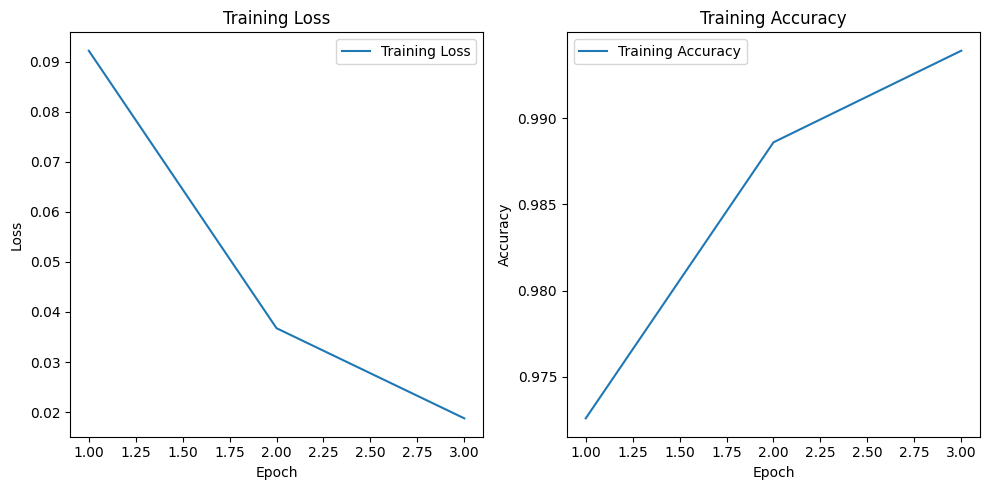

In [31]:
# Plot training loss and accuracy
plt.figure(figsize=(10, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1),train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1),train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

* Compute the average test loss (avg_test_loss) by dividing the total test loss by the number of batches in the test dataset.
* Compute the test accuracy (test_accuracy) by dividing the total number of correct predictions by the total number of predictions.

In [42]:
import torch

# Set the model to evaluation mode
model.eval()

# Initialize variables to track loss and accuracy
test_loss = 0
correct_predictions = 0
total_predictions = 0

# Disable gradient calculation
with torch.no_grad():
    for batch in tqdm(test_dataloader, total=len(test_dataloader)):
        batch_input_ids, batch_attention_masks, batch_labels = batch

        # Forward pass
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks, labels=batch_labels)
        loss = outputs.loss
        test_loss += loss.item()

        # Compute accuracy
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(preds == batch_labels.to(device)).item()
        total_predictions += len(preds)

# Compute average test loss
avg_test_loss = test_loss / len(test_dataloader)

# Compute test accuracy
test_accuracy = correct_predictions / total_predictions

print(f'Average Test Loss: {avg_test_loss}, Test Accuracy: {test_accuracy}')


100%|██████████| 447/447 [01:02<00:00,  7.17it/s]

Average Test Loss: 0.04227780863350092, Test Accuracy: 0.9904921700223713


In [46]:
print(f'Test Accuracy: {test_accuracy * 100:.4f}%')
print(f'Test Loss: {avg_test_loss:.4f}')

Test Accuracy: 99.0492%
Test Loss: 0.0423
